# 학습 목표
1. 약물성(Drug-likeness)의 개념과 중요성을 이해한다
2. 약물성 평가를 위한 다양한 규칙과 지표를 학습한다
3. 머신러닝 기반 약물성 예측 모델을 구현한다

# 1. 약물성(Drug-likeness)
- 약물성은 화합물이 약물로서 바람직한 특성을 얼마나 가지고 있는지를 나타내는 개념
- 약물성이 높은 화합물은 체내 흡수, 분포, 대사, 배설(ADME) 특성이 우수하고, 독성이 낮으며, 타겟 단백질과 상호작용할 가능성이 높음

# 2. 약물성 평가를 위한 규칙과 지표
- **Lipinski의 Rule of Five: 크리스토퍼 리핀스키(Christopher Lipinski)가 제안한 경험적 규칙으로, 경구 투여 약물의 생체이용률을 예측**
    - 분자량 < 500 Da
    - 옥탄올-물 분배계수(LogP) ≤ 5
    - 수소 결합 공여체(H-bond donors) ≤ 5
    - 수소 결합 수용체(H-bond acceptors) ≤ 10
    - 규칙 위반 개수가 1개 이하면 약물성이 높다고 평가
- Veber의 규칙: 다니엘 베버(Daniel Veber)가 제안한 규칙으로, 경구 생체이용률에 초점을 맞춤
    - 회전 가능한 결합(Rotatable bonds) ≤ 10
    - 극성 표면적(Polar surface area, PSA) ≤ 140 Å²
- Ghose 필터: 아쉬스 고스(Ashis Ghose)가 제안한 필터로, 약물 유사성을 평가
    - 분자량: 160-480 Da
    - LogP: -0.4 ~ 5.6
    - 원자 수: 20-70
    - 극성 표면적: 20-130 Å²
- 약물성 점수(Drug-likeness Score)
    - **QED(Quantitative Estimate of Drug-likeness): 0(낮음)~1(높음) 사이의 점수로 약물성 정량화**
    - **SA(Synthetic Accessibility) Score: 1(용이)~10(어려움) 사이의 점수로 합성 난이도 평가**
    - PAINS(Pan-Assay Interference Compounds) 필터: 약물 스크리닝에서 위양성을 유발할 수 있는 구조 식별

# 3. 약물성 스크리닝 실습
R05, QED를 이용한 필터링 실습을 진행한다.

## 3.1. 기본 설정

In [ ]:
# 필요 라이브러리 설치
!pip install rdkit

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, QED, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import rdMolDescriptors
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import SaltRemover
from tqdm import tqdm

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
!wget https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv
zinc_df = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
zinc_df = zinc_df[:25000]  # 처음 25,000개 화합물만 사용

print(f"로드된 화합물 수: {len(zinc_df)}")
print(zinc_df.head())

--2025-03-29 03:55:15--  https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22606589 (22M) [text/plain]
Saving to: ‘250k_rndm_zinc_drugs_clean_3.csv.4’

250k_rndm_zinc_drug 100%[===================>]  21.56M  85.0MB/s    in 0.3s    

2025-03-29 03:55:15 (85.0 MB/s) - ‘250k_rndm_zinc_drugs_clean_3.csv.4’ saved [22606589/22606589]

로드된 화합물 수: 25000
                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599

## 3.2. 데이터 전처리

분자 변환 중: 100%|██████████| 25000/25000 [00:47<00:00, 522.77it/s]


유효한 분자 수: 25000


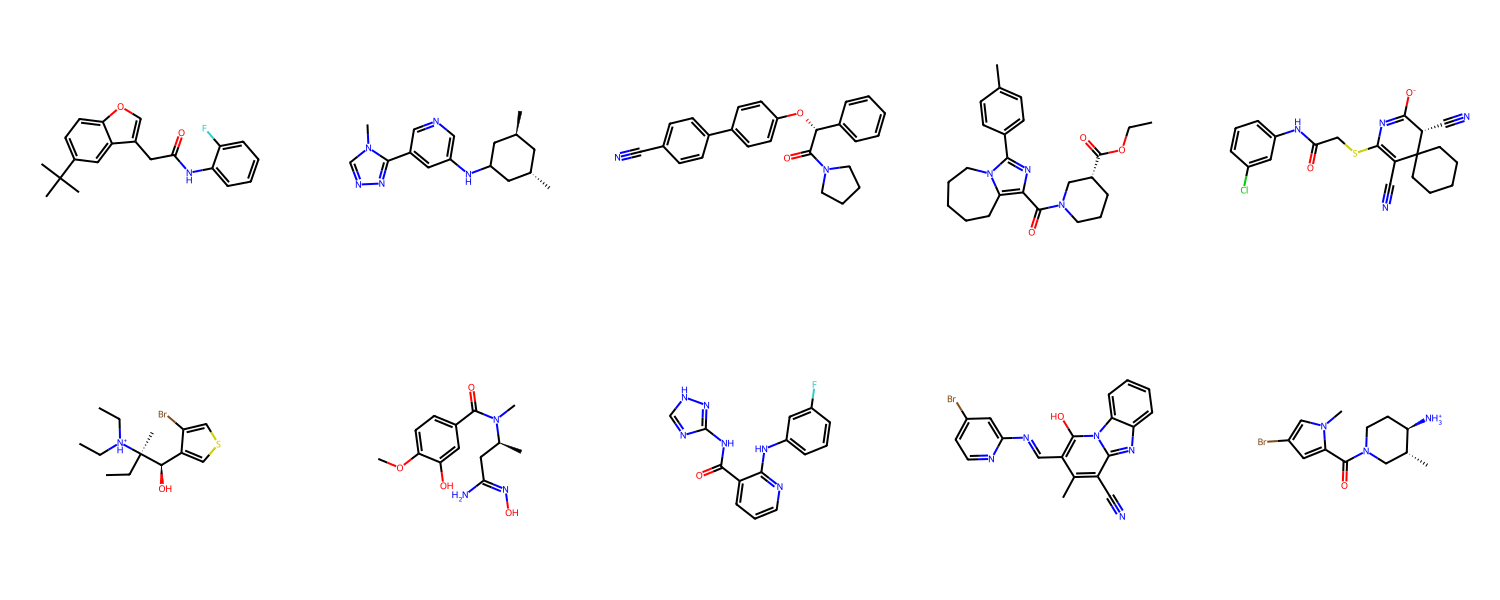

In [ ]:
# SMILES 문자열을 RDKit 분자 객체로 변환
def smiles_to_mol(smiles_list):
    mols = []
    valid_indices = []

    for i, smiles in enumerate(tqdm(smiles_list, desc="분자 변환 중")):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # 염 제거 (필요한 경우)
            remover = SaltRemover.SaltRemover()
            mol = remover.StripMol(mol)

            mols.append(mol)
            valid_indices.append(i)

    return mols, valid_indices

# 분자 객체 생성
mols, valid_indices = smiles_to_mol(zinc_df['smiles'])
print(f"유효한 분자 수: {len(mols)}")

# 유효한 분자만 포함하는 데이터프레임 생성
valid_df = zinc_df.iloc[valid_indices].reset_index(drop=True)
valid_df['mol'] = mols

# 일부 분자 시각화
def visualize_molecules(mols, n=10):
    sample_mols = mols[:n]
    img = MolsToGridImage(sample_mols, molsPerRow=5, subImgSize=(300, 300))
    return img

# 샘플 분자 시각화
sample_img = visualize_molecules(mols)
display(sample_img)

## 3.3.  Lipinski Rule of Five 구현

Calculating Lipinski parameters: 100%|██████████| 25000/25000 [00:18<00:00, 1377.06it/s]


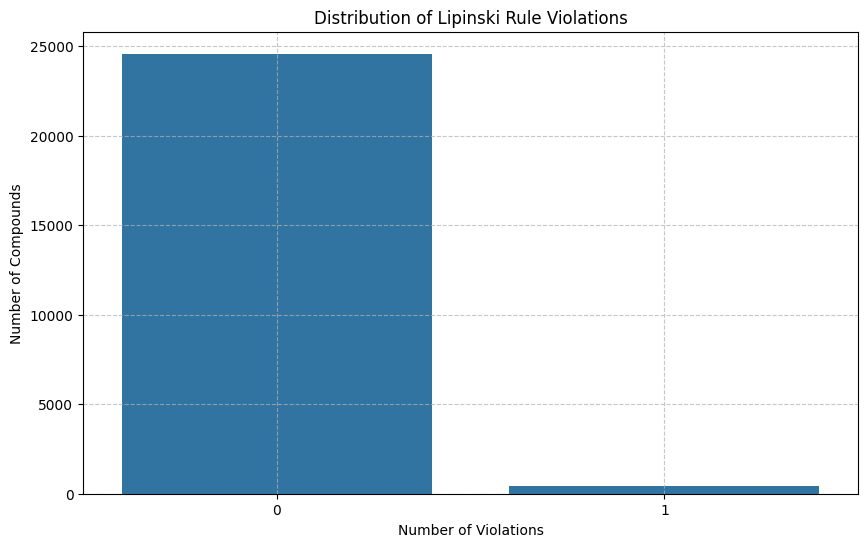

Compounds passing Lipinski Rule: 25000 (100.0%)


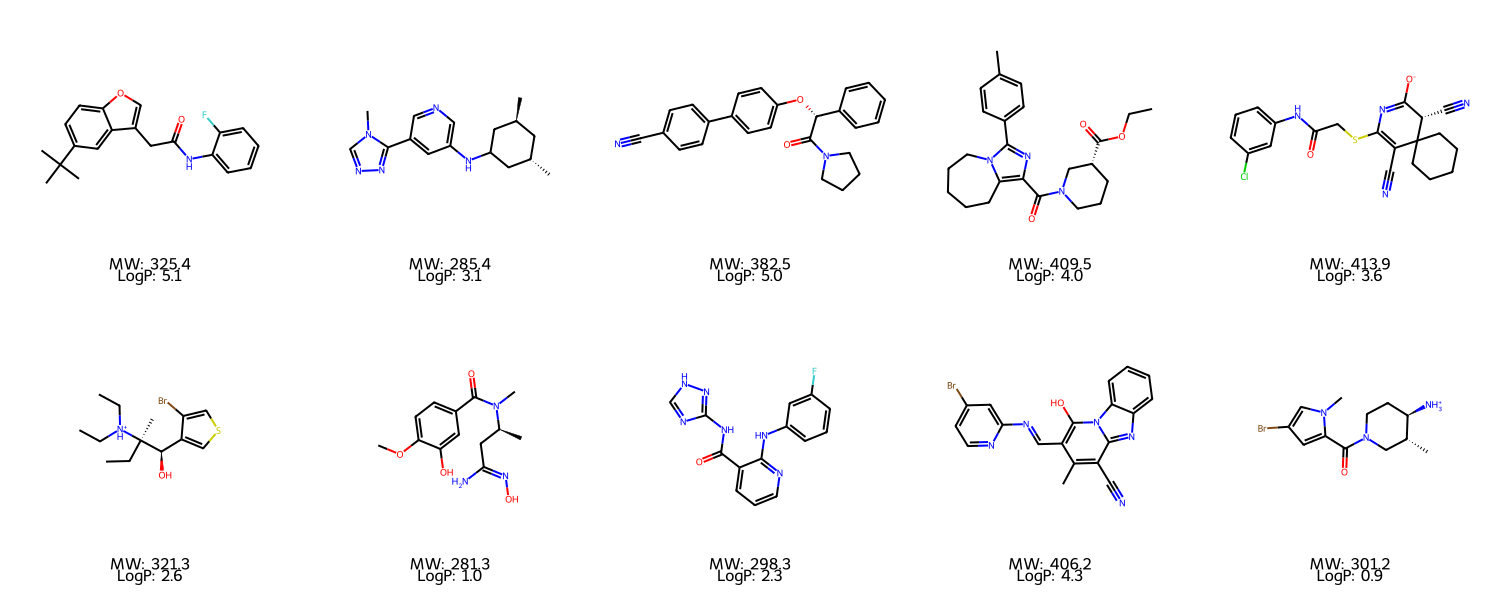

In [ ]:
def calculate_lipinski(mol):
    """Calculate Lipinski Rule of Five parameters"""
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Lipinski.NumHDonors(mol)
    h_acceptors = Lipinski.NumHAcceptors(mol)

    # Calculate number of violations
    violations = 0
    if mw > 500: violations += 1
    if logp > 5: violations += 1
    if h_donors > 5: violations += 1
    if h_acceptors > 10: violations += 1

    return {
        'MW': mw,
        'LogP': logp,
        'HBD': h_donors,
        'HBA': h_acceptors,
        'Lipinski_Violations': violations
    }

# Calculate Lipinski parameters for all molecules
lipinski_results = []
for mol in tqdm(mols, desc="Calculating Lipinski parameters"):
    lipinski_results.append(calculate_lipinski(mol))

# Add results to the dataframe
lipinski_df = pd.DataFrame(lipinski_results)
valid_df = pd.concat([valid_df, lipinski_df], axis=1)

# Visualize the distribution of Lipinski violations
plt.figure(figsize=(10, 6))
sns.countplot(x='Lipinski_Violations', data=valid_df)
plt.title('Distribution of Lipinski Rule Violations')
plt.xlabel('Number of Violations')
plt.ylabel('Number of Compounds')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('lipinski_violations.png')
plt.show()

# Compounds that pass Lipinski Rule (violations <= 1)
lipinski_pass = valid_df[valid_df['Lipinski_Violations'] <= 1]
print(f"Compounds passing Lipinski Rule: {len(lipinski_pass)} ({len(lipinski_pass)/len(valid_df)*100:.1f}%)")

# Visualize compounds that pass Lipinski Rule
lipinski_pass_mols = lipinski_pass['mol'].tolist()[:10]
lipinski_pass_img = MolsToGridImage(lipinski_pass_mols, molsPerRow=5, subImgSize=(300, 300),
                                   legends=[f"MW: {m:.1f}\nLogP: {l:.1f}"
                                           for m, l in zip(lipinski_pass['MW'][:10], lipinski_pass['LogP'][:10])])
display(lipinski_pass_img)

## 3.4.  QED(Quantitative Estimate of Drug-likeness) 계산

QED 계산 중: 100%|██████████| 25000/25000 [00:59<00:00, 422.54it/s]


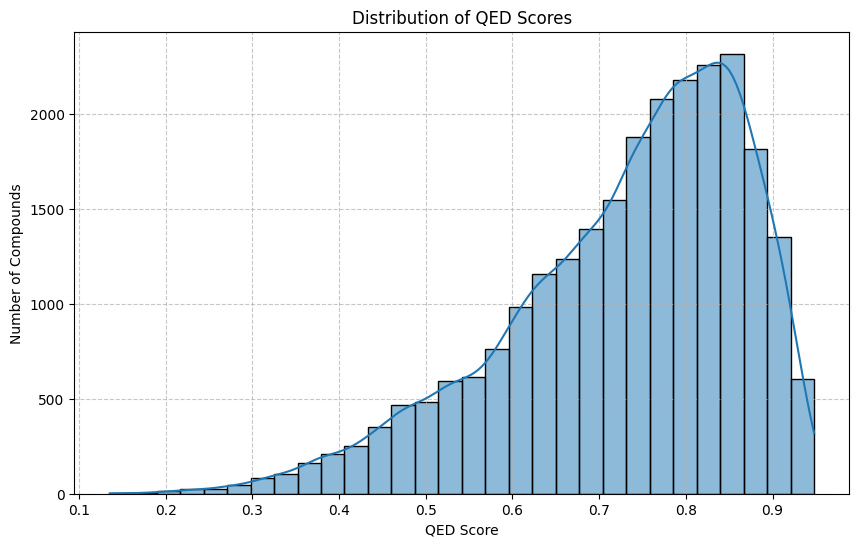

Compounds with QED > 0.8: 9338 (37.4%)


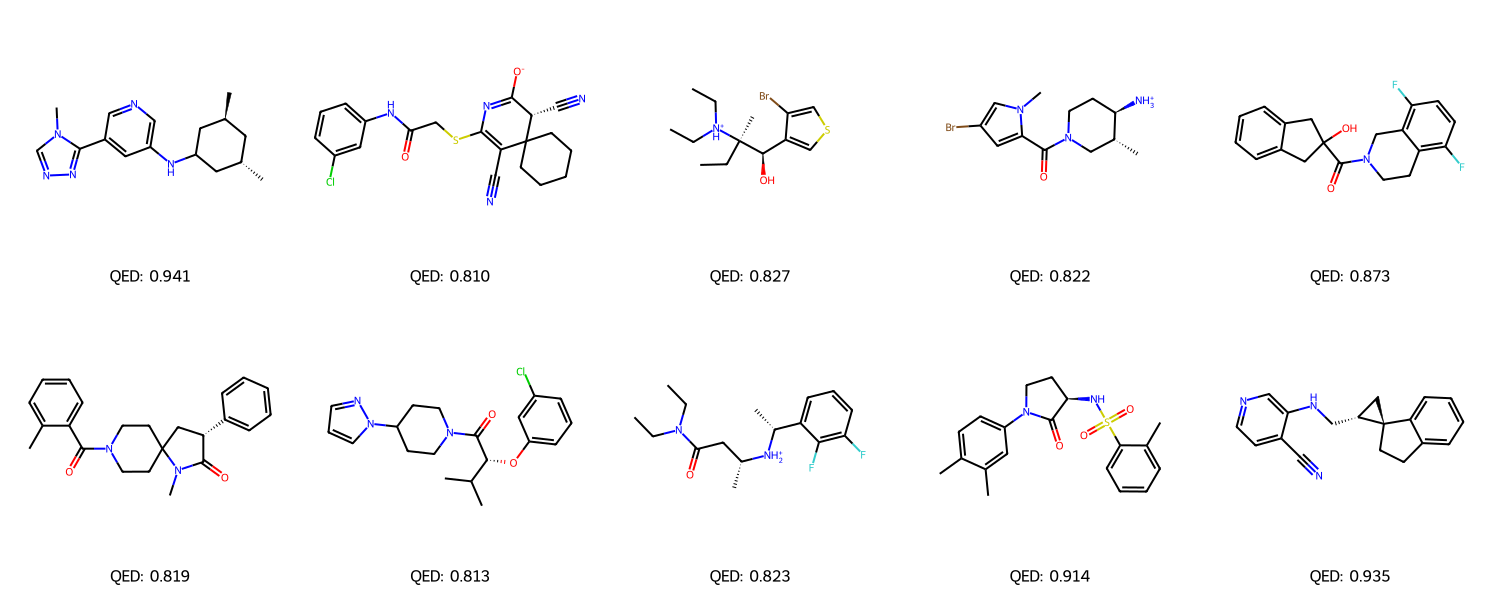

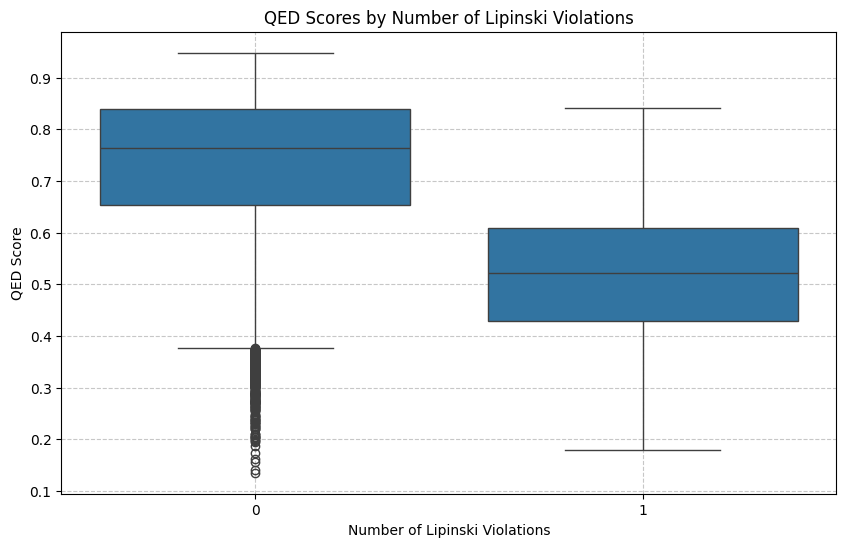

In [ ]:
# QED 계산 함수
def calculate_qed(mol):
    """QED 약물성 점수 계산"""
    try:
        qed_value = QED.qed(mol)
        return qed_value
    except:
        return np.nan

# 모든 분자에 대해 QED 계산
valid_df['QED'] = [calculate_qed(mol) for mol in tqdm(mols, desc="QED 계산 중")]

# Visualize QED distribution
plt.figure(figsize=(10, 6))
sns.histplot(valid_df['QED'], bins=30, kde=True)
plt.title('Distribution of QED Scores')
plt.xlabel('QED Score')
plt.ylabel('Number of Compounds')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('qed_distribution.png')
plt.show()

# Compounds with high QED scores (QED > 0.8)
high_qed = valid_df[valid_df['QED'] > 0.8]
print(f"Compounds with QED > 0.8: {len(high_qed)} ({len(high_qed)/len(valid_df)*100:.1f}%)")

# Visualize compounds with high QED scores
high_qed_mols = high_qed['mol'].tolist()[:10]
high_qed_img = MolsToGridImage(high_qed_mols, molsPerRow=5, subImgSize=(300, 300),
                             legends=[f"QED: {q:.3f}" for q in high_qed['QED'][:10]])
display(high_qed_img)

# Relationship between QED and Lipinski violations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lipinski_Violations', y='QED', data=valid_df)
plt.title('QED Scores by Number of Lipinski Violations')
plt.xlabel('Number of Lipinski Violations')
plt.ylabel('QED Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('qed_vs_lipinski.png')
plt.show()